In [1]:
import random
import math
from matplotlib import pyplot as plt
import datetime

In [2]:
L = 100 #league size
L_half = L / 2  
S = 100  #season 1000
n = 10  #dimension
p_c = 0.3
PSI1 = 0.2
PSI2 = 1.0
schedule = list()

In [3]:
class LeagueChampionshipAlgorithm(object):
    def __init__(self):
        return

    def league(self, choice):
        if choice == 0:
            path_w = 'LCA_SphereResult.txt'
        elif choice == 1:
            path_w = 'LCA_RosenbrockResult.txt'
        wfile = open(path_w, mode='w')
        if choice == 0:
            wfile.write('Sphere\n')
        elif choice == 1:
            wfile.write('Rosenbrock\n')

        global L, L_half
        X = self.getRandomTeam()
        if L % 2 == 1:  #If the number of teams is odd, create a dummy team
            DAMY_TEAM = [1000 for step in range(n)]
            X.append(DAMY_TEAM.copy())
            L += 1
            L_half += 1

        fX = list(0 for step in range(L))
        fX = self.optimizationFunction(choice, X, fX)  #Fitness
        nextX = list(X) #Temporary variable
        B = list(X)  #List of Best solution till now
        fB = list(fX)  #Optimal fitness
        f_best = min(fB)  #Best fitness value
        f_bList = list()
        f_bList.append(f_best) #Iteration wise

        t = 1
        schedule = self.leagueSchedule(t)
        wfile.write("t =%d, f_best=%f\n" % (t, f_best))
        while t <= S * (L - 1):
            if L % 2 == 1:
                X.append(DAMY_TEAM.copy())
            if t % 10 == 0:
                wfile.write("t =%d, f_best=%f\n" % (t, f_best)) #How frequently values are added to file
            Y = self.get_Y()
            for l in range(L):
                teamA, teamB, teamC, teamD = self.teamClassification(
                    X, t, l - 1)
                winner1 = self.winORlose(X, teamA, teamB, fX, f_best)
                winner2 = self.winORlose(X, teamC, teamD, fX, f_best)
                nextX[X.index(teamA)] = self.setTeamFormation(
                    X, B, Y, teamA, teamB, teamC, teamD, winner1, winner2)

            X = nextX.copy()

            if L % 2 == 1:
                del X[-1]
            fX = self.optimizationFunction(choice, X, fX)  #Fitness
            for l in range(L):
                if fX[l] < fB[l]:
                    B[l] = X[l]
                    fB[l] = fX[l]
            f_best = min(fB)
            f_bList.append(f_best)

            if t % (L - 1) == 0:
                #self.addOnModule() #add-onCan be added
                schedule = self.leagueSchedule(t)
            t += 1

        wfile.write("~~~~ Output result ~~~~\n")
        wfile.write("f(x) = %f\n" % f_best)
        self.opfun(fB, f_best)

        wfile.close()
        return f_bList

    def getRandomTeam(self):
        #Initial values of individual teams
        X = [[round(random.uniform(-10.0, 10.0), 6) for i in range(n)]
             for l in range(L)]  #Round to 6 digits
        return X

    def leagueSchedule(self, t):
        #League schedule settings
        if t == 1:
            schedule.append([l + 1 for l in range(L - 1)])
        randSche = random.sample([l + 1 for l in range(L - 1)], L - 1)
        schedule.append(randSche.copy())

        for l in range(L - 2):
            randSche.append(randSche.pop(0))
            schedule.append(randSche.copy())
        return schedule

    def teamClassification(self, X, t, l):
        """
        X[0]                   vs X[schedule[t][0]]
        X[schedule[t][L-2]]    vs X[schedule[t][1]]
        ...
        X[shcedule[t][L_half]] vs X[schedule[t][L_half-1]]
        """
        if l == -1:
            teamA = X[0]
            teamB = X[schedule[t][l + 1]]
            teamC = X[schedule[t][l + 2]]
            teamD = X[schedule[t][L - 1 - (l + 2)]]
        elif l == 0:
            teamA = X[schedule[t][l]]
            teamB = X[0]
            teamC = X[schedule[t][l + 2]]
            teamD = X[schedule[t][L - 1 - (l + 2)]]
        elif l == 1:
            teamA = X[schedule[t][l]]
            teamB = X[schedule[t][L - 1 - l]]
            teamC = X[0]
            teamD = X[schedule[t][l - 1]]
        elif l == 2:
            teamA = X[schedule[t][l]]
            teamB = X[schedule[t][L - 1 - l]]
            teamC = X[schedule[t][l - 2]]
            teamD = X[0]
        elif l < L_half:
            teamA = X[schedule[t][l]]
            teamB = X[schedule[t][L - 1 - l]]
            teamC = X[schedule[t][L - l + 1]]
            teamD = X[schedule[t][l - 2]]
        elif l == L_half - 1:
            teamA = X[schedule[t][l]]
            teamB = X[schedule[t][l + 1]]
            teamC = X[schedule[t][l + 3]]
            teamD = X[schedule[t][l - 2]]
        elif l == L_half:
            teamA = X[schedule[t][l]]
            teamB = X[schedule[t][l - 1]]
            teamC = X[schedule[t][l + 1]]
            teamD = X[schedule[t][l - 2]]
        elif l == L_half + 1:
            teamA = X[schedule[t][l]]
            teamB = X[schedule[t][l - 3]]
            teamC = X[schedule[t][l - 1]]
            teamD = X[schedule[t][l - 2]]
        elif l == L_half + 2:
            teamA = X[schedule[t][l]]
            teamB = X[schedule[t][l - 5]]
            teamC = X[schedule[t][l - 3]]
            teamD = X[schedule[t][l - 2]]
        elif l < L - 1:
            teamA = X[schedule[t][l]]
            teamB = X[schedule[t][L - l - 1]]
            teamC = X[schedule[t][L - l + 1]]
            teamD = X[schedule[t][l - 2]]
        return teamA, teamB, teamC, teamD

    def optimizationFunction(self, choice, X, fX):
        if choice is 0:
            #Sphere
            for l in range(L):
                fX[l] = 0
                #f(x) = \sigma{n}{i=1}x_i^2
                for i in range(n):
                    fX[l] += X[l][i]**2
            return fX
        elif choice is 1:
            #Rosenbrock
            for l in range(L):
                fX[l] = 0
                #f(x) = \sigma{n-1}{i=1}(100*(x_{i+1}-x_i)^2+(1-x_i)^2))
                for i in range(n - 1):
                    fX[l] += (
                        100 * (X[l][i + 1] - X[l][i])**2 + (1 - X[l][i])**2)

            return fX

    def winORlose(self, X, team1, team2, fX, f_best):
        Index1 = X.index(team1)
        Index2 = X.index(team2) #inversely proportional
        winPoint = (fX[Index2] - f_best) / (
            fX[Index2] + fX[Index1] - 2.0 * f_best)

        num = random.uniform(0.0, 1.0)
        #Victory
        if winPoint <= 0.5:
            if winPoint == 0.0:
                winner = team2
            elif num <= winPoint:
                winner = team1
            else:
                winner = team2
        else:
            if winPoint == 1.0:
                winner = team1
            elif winPoint <= num:
                winner = team2
            else:
                winner = team1
        return winner

    def get_Y(self):
        q0 = 1  #q_0=1   #Number of flags
        Y = list()  #Binary variable array
        y_sample = [i for i in range(n)]
        for i in range(L):
            y = [0 for num in range(n)]  #Binary variable
            a = random.uniform(0.0, 1.0)
            flagNum = (math.log(1 - (1 - (1 - p_c)**(n - q0 + 1)) * a) //
                       math.log(1 - p_c)) + q0 - 1
            q = int(flagNum)
            poInt = list(random.sample([l for l in range(n)], q))  #Which one
            poInt.sort()
            numy = 0
            numt = 0
            while numy < len(y) and numt < len(poInt):
                sa = y_sample[numy] - poInt[numt]
                if sa < 0:
                    numy += 1
                if sa == 0:
                    y[numy] = 1
                    numy += 1
                    numt += 1
                if sa > 0:
                    numt += 1
            Y.append(y)
        return Y

    def getRandom_rid(self):
        r_id1 = [random.uniform(0.0, 1.0) for i in range(n)]
        r_id2 = [random.uniform(0.0, 1.0) for i in range(n)]
        return r_id1, r_id2

    def addOnModule(self):
        return

    def setTeamFormation(self, X, B, Y, teamA, teamB, teamC, teamD, winner1,
                         winner2):
        r_id1, r_id2 = self.getRandom_rid()
        nextX = list(X)
        lA = X.index(teamA)
        lB = X.index(teamB)
        lC = X.index(teamC)
        lD = X.index(teamD)
        if winner1 == teamA and winner2 == teamC:  #S/T
            for i in range(n):
                nextX[lA][i] = B[lA][i] + Y[lA][i] * (
                    PSI1 * r_id1[i] * (X[lA][i] - X[lD][i]) + PSI1 * r_id2[i] *
                    (X[lA][i] - X[lB][i]))
        elif winner1 == teamA and winner2 == teamD:  #S/O
            for i in range(n):
                nextX[lA][i] = B[lA][i] + Y[lA][i] * (
                    PSI2 * r_id1[i] * (X[lD][i] - X[lA][i]) + PSI1 * r_id2[i] *
                    (X[lA][i] - X[lB][i]))
        elif winner1 == teamB and winner2 == teamC:  #W/T
            for i in range(n):
                nextX[lA][i] = B[lA][i] + Y[lA][i] * (
                    PSI1 * r_id1[i] * (X[lA][i] - X[lD][i]) + PSI2 * r_id2[i] *
                    (X[lB][i] - X[lA][i]))
        elif winner1 == teamB and winner2 == teamD:  #W/O
            for i in range(n):
                nextX[lA][i] = B[lA][i] + Y[lA][i] * (
                    PSI2 * r_id1[i] * (X[lD][i] - X[lA][i]) + PSI2 * r_id2[i] *
                    (X[lB][i] - X[lA][i]))
        return nextX[lA]

    def opfun(self, fB, f_best):
        print("~~~~ Output result ~~~~")
        print("f(x) = ", f_best)
        return


[0]:Sphere
[1]:Rosenbrock
Select Benchmark Function:1
~~~~ Output result ~~~~
f(x) =  27.397363783558717


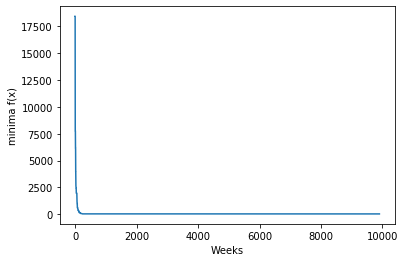

In [4]:
if __name__ == "__main__":
    print("[0]:Sphere")
    print("[1]:Rosenbrock")
    choice = int(input("Select Benchmark Function:"))
    LCA = LeagueChampionshipAlgorithm() # LCA is object of above class

    y = LCA.league(choice)

    x = list(t for t in range(S * (L - 1)+1))

    pf = plt.figure()
    plt.xlabel("Weeks")
    plt.ylabel("minima f(x)")
    plt.plot(x, y, label="LCA")
